In [1]:
#import useful files
import statistics as stat
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#file path with glob
path = "Tektronix_data/"
all_files = glob.glob(path + "*.csv")

In [3]:
#turn all 512 files into lists
var = [pd.read_csv(filename,index_col=None,header=0,skiprows=17) for filename in all_files]

In [4]:
#concat all lists and turn into 1 big dataframe
dataframe = pd.concat(var,axis=0,ignore_index=True)

In [5]:
#renaming the headers (they came as Channel 1,2,3,4 - need to know what they represent)
rename = ['Time','Channel_1','Raman_Channel_Detection_640nm','Raman_Channel_Detection_660nm','Green_Channel_532nm']
dataframe.columns = rename

In [6]:
dataframe.head()

,Time,Channel_1,Raman_Channel_Detection_640nm,Raman_Channel_Detection_660nm,Green_Channel_532nm
0,-9.430000e-08,-0.004,0.002,-4.000000e-03,0.008
1,-9.410000e-08,-0.004,-0.002,4.440890e-17,0.008
2,-9.390000e-08,-0.004,-0.010,-8.000000e-03,0.004
3,-9.370000e-08,-0.012,-0.002,-8.000000e-03,0.008
4,-9.350000e-08,-0.004,-0.010,-4.000000e-03,0.008


In [7]:
#change the data type
Clean_dataframe = dataframe.astype(float)

### Singular pulses, needed for second part of the analysis - undersampling

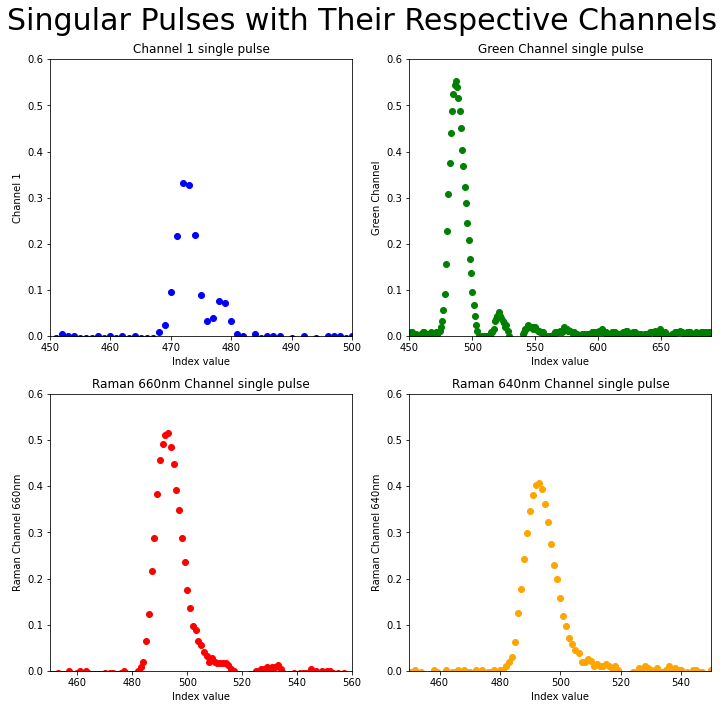

In [8]:
#Single pulse!
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax1.scatter(Clean_dataframe.index,Clean_dataframe.Channel_1, c='blue')
ax1.set_title('Channel 1 single pulse')
ax1.set(xlabel = 'Index value', ylabel = 'Channel 1',xlim = (450,500), ylim = (0,0.6))

ax2.scatter(Clean_dataframe.index,Clean_dataframe.Green_Channel_532nm, c='green')
ax2.set_title('Green Channel single pulse')
ax2.set(xlabel = 'Index value', ylabel = 'Green Channel',xlim = (450,690), ylim = (0,0.6))

ax3.scatter(Clean_dataframe.index,Clean_dataframe.Raman_Channel_Detection_660nm, c='red')
ax3.set_title('Raman 660nm Channel single pulse')
ax3.set(xlabel = 'Index value', ylabel = 'Raman Channel 660nm',xlim = (450,560), ylim = (0,0.6))

ax4.scatter(Clean_dataframe.index,Clean_dataframe.Raman_Channel_Detection_640nm, c='orange')
ax4.set_title('Raman 640nm Channel single pulse')
ax4.set(xlabel = 'Index value', ylabel = 'Raman Channel 640nm',xlim = (450,550), ylim = (0,0.6))

fig.suptitle('Singular Pulses with Their Respective Channels', fontsize=30)
plt.tight_layout()
plt.show()

Since we are interested in the sampling of the oscilloscope, the horizontal axis is now just index values rather than the time.

In [9]:
uniform_dataframe=Clean_dataframe.assign(Time = Clean_dataframe['Time']*1e9)

In [10]:
#Setting the Time as the index column
uniform_dataframe.set_index("Time",drop=True,inplace=True)

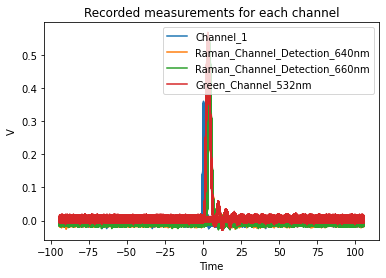

In [11]:
#Plot all columns against Time
plot_columns = ['Channel_1','Raman_Channel_Detection_640nm','Raman_Channel_Detection_660nm','Green_Channel_532nm']
uniform_dataframe[plot_columns].plot()

plt.xlabel('Time')
plt.ylabel('V')
plt.title('Recorded measurements for each channel')
plt.show()

### Calculating averages and SD's

In [12]:
#Split the large dataframe into 512 smaller dataframes
def split_dataframe_by_position(df, splits):
    dataframes = []
    index_to_split = len(df) // splits
    start = 0
    end = index_to_split
    for split in range(splits):
        temporary_df = df.iloc[start:end, :]
        dataframes.append(temporary_df)
        start += index_to_split
        end += index_to_split
    return dataframes
split_dataframes = split_dataframe_by_position(uniform_dataframe, 512)
#Test if our split is working
print('Quick test, the max value of the last dataframe = ',split_dataframes[511].Channel_1.max(),'V')

Quick test, the max value of the last dataframe =  0.34 V


In [13]:
#Create code that returns the FWHM value and its 2 locations (time duration)
def FWHM_time_duration(X,Y):
    half_max = max(Y) / 2.
    #find the full width at half maxima, we choose denominator to be 2
    #if we want full width at tenth maxima, we choose it to be 10 
    frac = 2
    d = Y - (max(Y) / frac) 
    #locate and subtract the 2 points in x axis (which is difference in time) for FWHM duration
    indexes = np.where(d > 0)[0]
    return abs(X[indexes[-1]] - X[indexes[0]])

def FWHM_value(Y):
    FWHM = max(Y)/2
    return FWHM

### Results for Channel 1

In [14]:
#For loop puts all the local Max Voltages into an empty list called localMaxVoltages, the Time of that occurance and
#FWHM values
localMaxVoltage_Channel1 = []
localMaxVoltageTime_Channel1 = []
pulseDurations_Channel1 = []
FWHM_values_Channel1 = []

i = 0
for i in range(0,511,1):
    localMaxVoltage_Channel1.append(split_dataframes[i].Channel_1.max())
    localMaxVoltageTime_Channel1.append(split_dataframes[i].Channel_1.idxmax())
    pulseDurations_Channel1.append(FWHM_time_duration(split_dataframes[i].index,split_dataframes[i].Channel_1))
    FWHM_values_Channel1.append(FWHM_value(split_dataframes[i].Channel_1))

In [17]:
print('Average maximum of the pulse for channel 1 = {0} V'.format(np.average(localMaxVoltage_Channel1)))
print('Average time of occurance of the max pulse for channel 1 = {0} ns'.format(np.average(localMaxVoltageTime_Channel1)))
print('Average pulse duration for channel 1 = {0} ns'.format(np.average(pulseDurations_Channel1)))
print('Average value for the FWHM for channel 1 = {0} V'.format(np.average(FWHM_values_Channel1)))

Average maximum of the pulse for channel 1 = 0.331945205479452 V
Average time of occurance of the max pulse for channel 1 = 0.285518590998043 ns
Average pulse duration for channel 1 = 0.5350293542074364 ns
Average value for the FWHM for channel 1 = 0.165972602739726 V


In [18]:
print('Standard deviation for the maximum of the pulse for channel 1 = {0} V'.format(np.std(localMaxVoltage_Channel1)))
print('Standard deviation for time of occurance of the max pulse for channel 1 = {0} ns'.format(np.std(localMaxVoltageTime_Channel1)))
print('Standard deviation of pulse duration for channel 1 = {0} ns'.format(np.std(pulseDurations_Channel1)))
print('Standard deviation of value for the FWHM for channel 1 = {0} V'.format(np.std(FWHM_values_Channel1)))

Standard deviation for the maximum of the pulse for channel 1 = 0.009165414630510044 V
Standard deviation for time of occurance of the max pulse for channel 1 = 0.05618040505987667 ns
Standard deviation of pulse duration for channel 1 = 0.09366399705228234 ns
Standard deviation of value for the FWHM for channel 1 = 0.004582707315255022 V


### Results for Green Channel

In [19]:
#For loop puts all the local Max Voltages into an empty list called localMaxVoltages, the Time of that occurance and
#FWHM values
localMaxVoltage_greenChannel = []
localMaxVoltageTime_greenChannel = []
pulseDurations_greenChannel = []
FWHM_values_greenChannel = []

i = 0
for i in range(0,511,1):
    localMaxVoltage_greenChannel.append(split_dataframes[i].Green_Channel_532nm.max())
    localMaxVoltageTime_greenChannel.append(split_dataframes[i].Green_Channel_532nm.idxmax())
    pulseDurations_greenChannel.append(FWHM_time_duration(split_dataframes[i].index,split_dataframes[i].Green_Channel_532nm))
    FWHM_values_greenChannel.append(FWHM_value(split_dataframes[i].Green_Channel_532nm))

In [20]:
print('Average maximum of the pulse for Green Channel 532nm = {0} V'.format(np.average(localMaxVoltage_greenChannel)))
print('Average time of occurance of the max pulse for Green Channel 532nm = {0} ns'.format(np.average(localMaxVoltageTime_greenChannel)))
print('Average pulse duration for Green Channel 532nm = {0} ns'.format(np.average(pulseDurations_greenChannel)))
print('Average value for the FWHM for Green Channel 532nm = {0} V'.format(np.average(FWHM_values_greenChannel)))

Average maximum of the pulse for Green Channel 532nm = 0.5541213307240704 V
Average time of occurance of the max pulse for Green Channel 532nm = 3.140704500978474 ns
Average pulse duration for Green Channel 532nm = 2.6931506849315068 ns
Average value for the FWHM for Green Channel 532nm = 0.2770606653620352 V


In [21]:
print('Standard deviation for the maximum of the pulse for Green Channel 532nm = {0} V'.format(np.std(localMaxVoltage_greenChannel)))
print('Standard deviation for time of occurance of the max pulse for Green Channel 532nm = {0} ns'.format(np.std(localMaxVoltageTime_greenChannel)))
print('Standard deviation of pulse duration for Green Channel 532nm = {0} ns'.format(np.std(pulseDurations_greenChannel)))
print('Standard deviation of value for the FWHM for Green Channel 532nm = {0} V'.format(np.std(FWHM_values_greenChannel)))

Standard deviation for the maximum of the pulse for Green Channel 532nm = 0.004124405310891265 V
Standard deviation for time of occurance of the max pulse for Green Channel 532nm = 0.10720927446634602 ns
Standard deviation of pulse duration for Green Channel 532nm = 0.09976515866319512 ns
Standard deviation of value for the FWHM for Green Channel 532nm = 0.0020622026554456326 V


### Results for Raman Channel 660nm

In [22]:
#For loop puts all the local Max Voltages into an empty list called localMaxVoltages, the Time of that occurance and
#FWHM values
localMaxVoltage_ramanChannel660nm = []
localMaxVoltageTime_ramanChannel660nm = []
pulseDurations_ramanChannel660nm = []
FWHM_values_ramanChannel660nm = []

i = 0
for i in range(0,511,1):
    localMaxVoltage_ramanChannel660nm.append(split_dataframes[i].Raman_Channel_Detection_660nm.max())
    localMaxVoltageTime_ramanChannel660nm.append(split_dataframes[i].Raman_Channel_Detection_660nm.idxmax())
    pulseDurations_ramanChannel660nm.append(FWHM_time_duration(split_dataframes[i].index,split_dataframes[i].Raman_Channel_Detection_660nm))
    FWHM_values_ramanChannel660nm.append(FWHM_value(split_dataframes[i].Raman_Channel_Detection_660nm))

In [23]:
print('Average maximum of the pulse for Raman Channel 660nm = {0} V'.format(np.average(localMaxVoltage_ramanChannel660nm)))
print('Average time of occurance of the max pulse for Raman Channel 660nm = {0} ns'.format(np.average(localMaxVoltageTime_ramanChannel660nm)))
print('Average pulse duration for Raman Channel 660nm = {0} ns'.format(np.average(pulseDurations_ramanChannel660nm)))
print('Average value for the FWHM for Raman Channel 660nm = {0} V'.format(np.average(FWHM_values_ramanChannel660nm)))

Average maximum of the pulse for Raman Channel 660nm = 0.49683757338551854 V
Average time of occurance of the max pulse for Raman Channel 660nm = 4.247162426614482 ns
Average pulse duration for Raman Channel 660nm = 1.9589041095890414 ns
Average value for the FWHM for Raman Channel 660nm = 0.24841878669275927 V


In [24]:
print('Standard deviation for the maximum of the pulse for Raman Channel 660nm = {0} V'.format(np.std(localMaxVoltage_ramanChannel660nm)))
print('Standard deviation for time of occurance of the max pulse for Raman Channel 660nm = {0} ns'.format(np.std(localMaxVoltageTime_ramanChannel660nm)))
print('Standard deviation of pulse duration for Raman Channel 660nm = {0} ns'.format(np.std(pulseDurations_ramanChannel660nm)))
print('Standard deviation of value for the FWHM for Raman Channel 660nm = {0} V'.format(np.std(FWHM_values_ramanChannel660nm)))

Standard deviation for the maximum of the pulse for Raman Channel 660nm = 0.014262394176771893 V
Standard deviation for time of occurance of the max pulse for Raman Channel 660nm = 0.09745675460823133 ns
Standard deviation of pulse duration for Raman Channel 660nm = 0.08732809561922845 ns
Standard deviation of value for the FWHM for Raman Channel 660nm = 0.007131197088385947 V


### Results for Raman Channel 640nm

In [25]:
#For loop puts all the local Max Voltages into an empty list called localMaxVoltages, the Time of that occurance and
#FWHM values
localMaxVoltage_ramanChannel640nm = []
localMaxVoltageTime_ramanChannel640nm = []
pulseDurations_ramanChannel640nm = []
FWHM_values_ramanChannel640nm = []

i = 0
for i in range(0,511,1):
    localMaxVoltage_ramanChannel640nm.append(split_dataframes[i].Raman_Channel_Detection_640nm.max())
    localMaxVoltageTime_ramanChannel640nm.append(split_dataframes[i].Raman_Channel_Detection_640nm.idxmax())
    pulseDurations_ramanChannel640nm.append(FWHM_time_duration(split_dataframes[i].index,split_dataframes[i].Raman_Channel_Detection_640nm))
    FWHM_values_ramanChannel640nm.append(FWHM_value(split_dataframes[i].Raman_Channel_Detection_640nm))

In [26]:
print('Average maximum of the pulse for Raman Channel 640nm = {0} V'.format(np.average(localMaxVoltage_ramanChannel640nm)))
print('Average time of occurance of the max pulse for Raman Channel 640nm = {0} ns'.format(np.average(localMaxVoltageTime_ramanChannel640nm)))
print('Average pulse duration for Raman Channel 640nm = {0} ns'.format(np.average(pulseDurations_ramanChannel640nm)))
print('Average value for the FWHM for Raman Channel 640nm = {0} V'.format(np.average(FWHM_values_ramanChannel640nm)))

Average maximum of the pulse for Raman Channel 640nm = 0.40228962818003916 V
Average time of occurance of the max pulse for Raman Channel 640nm = 4.286301369863013 ns
Average pulse duration for Raman Channel 640nm = 2.108023483365949 ns
Average value for the FWHM for Raman Channel 640nm = 0.20114481409001958 V


In [27]:
print('Standard deviation for the maximum of the pulse for Raman Channel 640nm = {0} V'.format(np.std(localMaxVoltage_ramanChannel640nm)))
print('Standard deviation for time of occurance of the max pulse for Raman Channel 640nm = {0} ns'.format(np.std(localMaxVoltageTime_ramanChannel640nm)))
print('Standard deviation of pulse duration for Raman Channel 640nm = {0} ns'.format(np.std(pulseDurations_ramanChannel640nm)))
print('Standard deviation of value for the FWHM for Raman Channel 640nm = {0} V'.format(np.std(FWHM_values_ramanChannel640nm)))

Standard deviation for the maximum of the pulse for Raman Channel 640nm = 0.008651225836395514 V
Standard deviation for time of occurance of the max pulse for Raman Channel 640nm = 0.10033319821218437 ns
Standard deviation of pulse duration for Raman Channel 640nm = 0.09967759886090902 ns
Standard deviation of value for the FWHM for Raman Channel 640nm = 0.004325612918197757 V


### sampling rate of osc.
__[this website](https://testequipmentsurplus.com/product/tds540-tektronix/)__ sampling rate of a certain tektronix osc, check if that is the same as the one we use, then maybe **actually experimentally check the sampling rate** i.e. take a measurement where 3 channels are taken off the osc, compare a scatter plot of that with the one we have of 4 channels.

Sampling rate of Picoscope: 1.25GS/s.

Proof below:
<img src="1.25GS sampling for Picoscope 6404C.PNG" alt="drawing" width="3000"/> 

Taken from __[PicoScope Manual](https://www.farnell.com/datasheets/2162834.pdf)__

Below is the STD for Channel 1 for picoscope data - this will be our undersampled data, compare with our results here and comment on how much more accurate (in terms of STD) it is to have a well sampled data.

<img src="STD for Channel 1 - Picoscope.PNG" alt="drawing" width="3000"/>

### Correlation

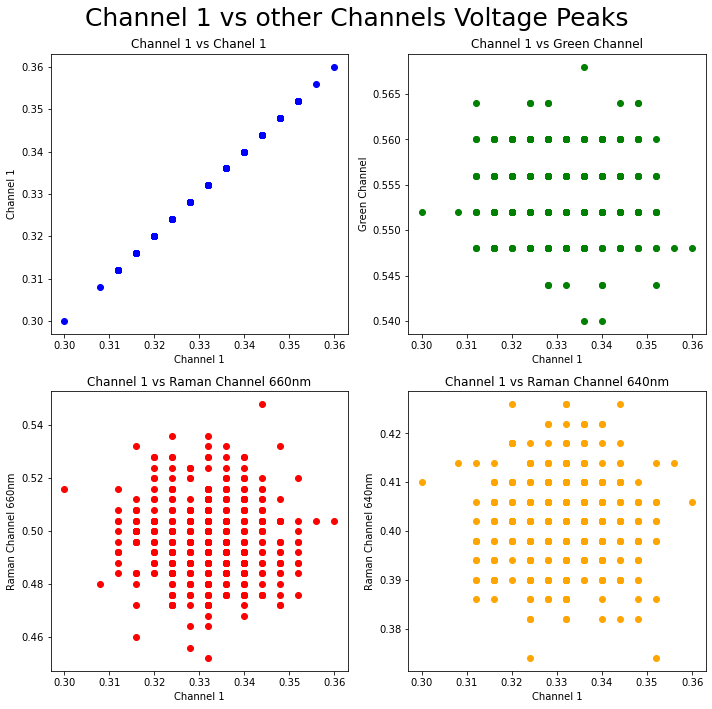

In [44]:
#Channel 1 vs other Channels Voltage Peaks
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax1.scatter(localMaxVoltage_Channel1,localMaxVoltage_Channel1, c='blue')
ax1.set_title('Channel 1 vs Chanel 1')
ax1.set(xlabel = 'Channel 1', ylabel = 'Channel 1')

ax2.scatter(localMaxVoltage_Channel1,localMaxVoltage_greenChannel, c='green')
ax2.set_title('Channel 1 vs Green Channel')
ax2.set(xlabel = 'Channel 1', ylabel = 'Green Channel')

ax3.scatter(localMaxVoltage_Channel1,localMaxVoltage_ramanChannel660nm, c='red')
ax3.set_title('Channel 1 vs Raman Channel 660nm')
ax3.set(xlabel = 'Channel 1', ylabel = 'Raman Channel 660nm')

ax4.scatter(localMaxVoltage_Channel1,localMaxVoltage_ramanChannel640nm, c='orange')
ax4.set_title('Channel 1 vs Raman Channel 640nm')
ax4.set(xlabel = 'Channel 1', ylabel = 'Raman Channel 640nm')

fig.suptitle('Channel 1 vs other Channels Voltage Peaks', fontsize=25)
plt.tight_layout()
plt.show()

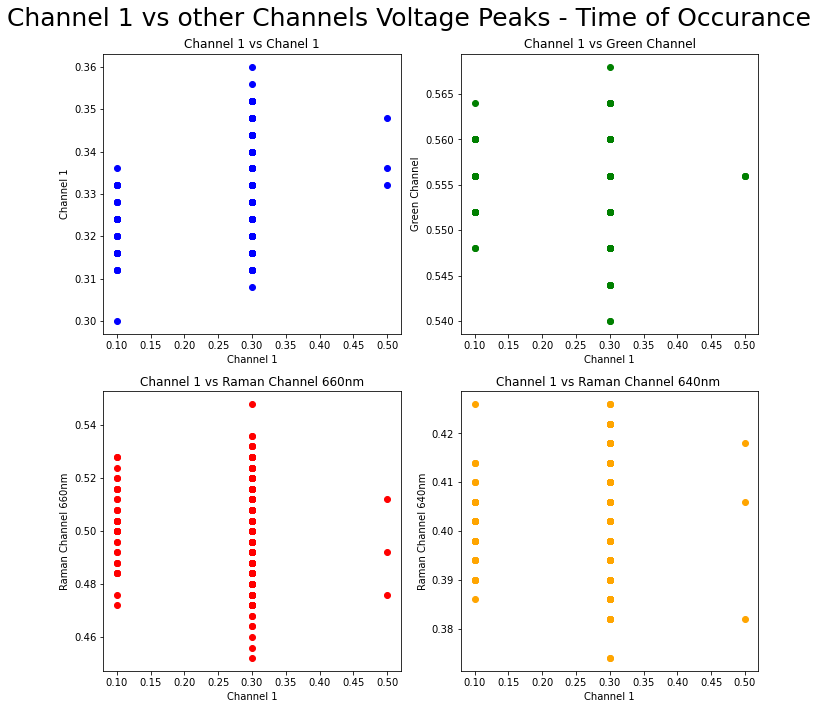

In [43]:
#Channel 1 vs other Channels Voltage Peaks - Time of Occurance
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

ax1.scatter(localMaxVoltageTime_Channel1,localMaxVoltage_Channel1, c='blue')
ax1.set_title('Channel 1 vs Chanel 1')
ax1.set(xlabel = 'Channel 1', ylabel = 'Channel 1')

ax2.scatter(localMaxVoltageTime_Channel1,localMaxVoltage_greenChannel, c='green')
ax2.set_title('Channel 1 vs Green Channel')
ax2.set(xlabel = 'Channel 1', ylabel = 'Green Channel')

ax3.scatter(localMaxVoltageTime_Channel1,localMaxVoltage_ramanChannel660nm, c='red')
ax3.set_title('Channel 1 vs Raman Channel 660nm')
ax3.set(xlabel = 'Channel 1', ylabel = 'Raman Channel 660nm')

ax4.scatter(localMaxVoltageTime_Channel1,localMaxVoltage_ramanChannel640nm, c='orange')
ax4.set_title('Channel 1 vs Raman Channel 640nm ')
ax4.set(xlabel = 'Channel 1', ylabel = 'Raman Channel 640nm')

fig.suptitle('Channel 1 vs other Channels Voltage Peaks - Time of Occurance', fontsize=25)
plt.tight_layout()
plt.show()